# 1.

Primero se expondrán las respuestas de preguntas no-bonus.

In [3]:
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import numpy as np
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import matplotlib.pyplot as pltp
import pandas as pd

Para los siguientes sistemas considere que para las reacciones:
$$
C_6H_6 + Cl_2 -> C_6H_6Cl + HCl , k1 = 0.412 L/ (kmol h)\\
C_6H_5Cl + Cl_2 -> C_6H_4Cl_2 + HCl, k2 = 0.055 L/ (kmol h)
$$
- A: $C_6H_6$ (Benceno)
- B: $Cl_2$ (Cloro)
- C: $HCl$ (HCl)
- D: $C_6H_6 Cl$ (Monoclorobenceno)
- E: $C_6H_4Cl_2$ (Diclorobenceno)


## A

In [4]:

def pfr_dV(t, x, k1, k2, v):
    '''
    Define el sistema de ecuciones diferenciales para el reactor de flujo pistón (PFR).
    Este toma la forma 
    dF/dV = r
    donde F es el vector de flujos molares y r es el vector de velocidades de reacción.
    ---
    Reference:
    Fogler, H. S. (2016). Elements of chemical reaction engineering (Fifth edition). Prentice-Hall, Pearson.
    Pagina 16.
    
    '''
    Ca, Cb, Cc, Cd, Ce = x
    dCa_dV = 1/v * (-k1 * Ca * Cb) # benceno
    dCb_dV = 1/v * (-k1 * Ca * Cb - k2 * Cb * Cc) # cl2
    dCc_dV = 1/v * (k1 * Ca * Cb + k2 * Cb * Cc) # hcl
    dCd_dV = 1/v * (k1 * Ca * Cb - k2 * Cb * Cc) # monoclorobenceno
    dCe_dV = 1/v * (k2 * Cb * Cc) # diclorobenceno
    return [dCa_dV, dCb_dV, dCc_dV, dCd_dV, dCe_dV]

# definimos los valores que conocemos
# constantes de velocidad
k1 = 0.412 # L/kmol h
k2 = 0.055 # L/kmol h
# concentraciones del flujo de entrada
Ca0 = 1 # kmol / L
Cb0 = 5 # kmol / L
Cc0 = 0 # kmol / L
Cd0 = 0 # kmol / L
Ce0 = 0 # kmol / L
# valor del flujo de entrada
v0 = 10 # m^3/h
# ahora escalamos para que v0 quede en unidades de L/h
v0 = v0 * 1000 # L/h
# tamaño de reactores
V1 = 5.56 # m^3
V2 = 11.61 # m^3
# ahora escalamos para que V1 y V2 queden en unidades de L
V1 = V1 * 1000 # L
V2 = V2 * 1000 # L
## debido a que son dos pfr en serie, el volumen total es:
V_total = V1 + V2 # L


Es posible simplificar la solución de este sistema al pre-calcular los flujos a través de las corrientes, tomando en cuenta el valor inicial de la corriente de reciclo.

In [12]:
def define_volumes(v0, vR):
    v0 = v0
    vR = vR
    v1 = v0 + vR
    v2 = v1
    v3 = v0 # estado estacionario
    return v0, v1, v2, v3, vR

c0 = [Ca0, Cb0, Cc0, Cd0, Ce0]  # condiciones iniciales

# supuesto inicial para corriente de reciclo
vrs = np.linspace(100, 2*v0, 100) # L/h
dict_results = {}

# empezamos resolviendo el sistema
for vr in vrs:
    converged = False
    # initial guess de CaR
    CaR = 0
    v0, v1, v2, v3, vr = define_volumes(v0, vr)
    while not converged:
        # punto de mezcla 0, 1, vR
        
        Ca1 = (Ca0 * v0 + CaR * vr) / v1
        Cb1 = (Cb0 * v0 ) / v1
        # balance PFR 1 con PFR 2 en serie 
        c1 = [Ca1, Cb1, 0, 0, 0]  # condiciones iniciales pfr 1
        sol = solve_ivp(pfr_dV, [0, V_total], c1, args=(k1, k2, v1), method='BDF')
        Ca2, Cb2, Cc2, Cd2, Ce2 = sol.y[:, -1]
        # balance separador de benceno
        CaR_new = (Ca2 * v2) / vr
        Cb3 = (Cb2 * v2) / v3
        Cc3 = (Cc2 * v2) / v3
        Cd3 = (Cd2 * v2) / v3
        Ce3 = (Ce2 * v2) / v3
        # convergencia
        if abs(CaR_new - CaR) < 1e-6:
            converged = True
        CaR = CaR_new
    dict_results[vr] = (Cb3, Cc3, Cd3, Ce3) # guardamos los resultados una vez convergidos


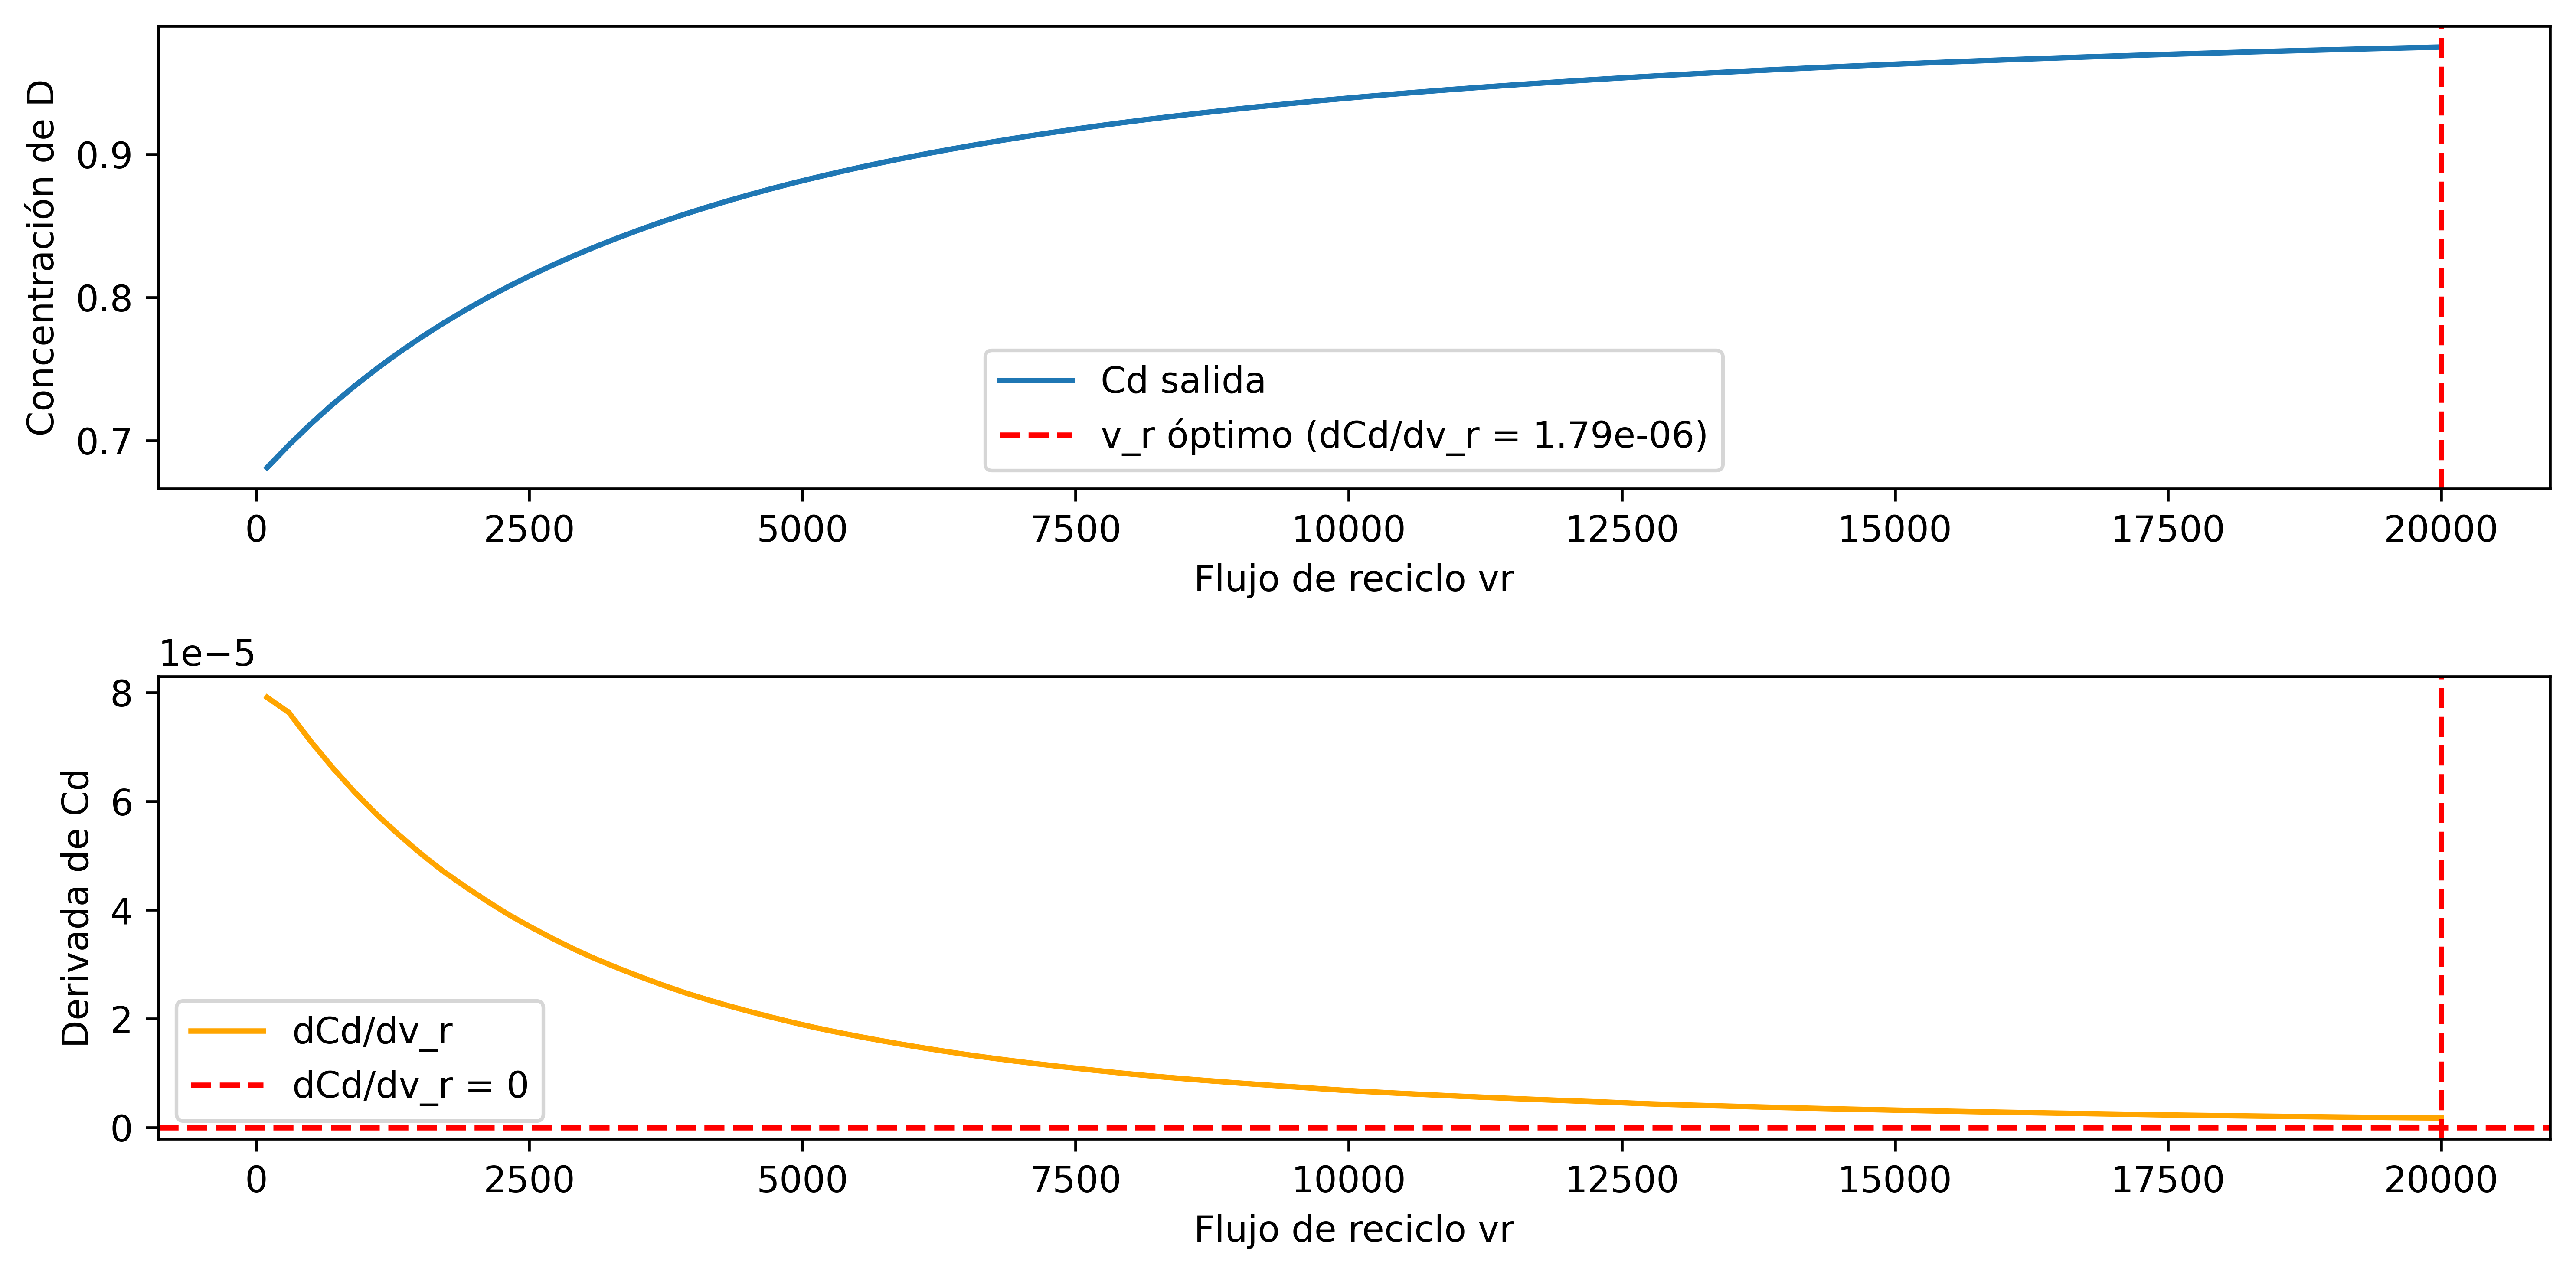

In [13]:
# calculamos cuando la concentracion de D es maxima a partir de v_r
# derivada
cdouts = np.array([dict_results[vr][2] for vr in vrs]) # concentracion de D en salida
dd_dvrs = np.gradient(cdouts, vrs)
# cerca de 0
idx_max = np.argmin(dd_dvrs) # el minimo de la derivada
vrs_opt = vrs[idx_max]
fig, ax = plt.subplots(2, 1, figsize=(10,5), dpi = 600)

ax[0].plot(vrs, cdouts, label='Cd salida')
ax[0].set_xlabel('Flujo de reciclo vr')
ax[0].set_ylabel('Concentración de D')
ax[0].axvline(vrs_opt, color='red', linestyle='--', label=f'v_r óptimo (dCd/dv_r = {dd_dvrs[idx_max]:.2e})')
ax[0].legend()

ax[1].plot(vrs, dd_dvrs, label='dCd/dv_r', color='orange')
ax[1].set_xlabel('Flujo de reciclo vr')
ax[1].set_ylabel('Derivada de Cd')
ax[1].axhline(0, color='red', linestyle='--', label='dCd/dv_r = 0')
ax[1].axvline(vrs_opt, color='red', linestyle='--')
ax[1].legend()
plt.tight_layout()

Podemos ver que la función de concentración de monoclorobenceno vs el flujo de reciclo es monotonica y creciente, por lo cual un valor alto funciona. Así, usamos un valor donde la derivada sea cercana a 0, por ejemplo, el doble de la entrada al sistema (2v0).
Así, podemos calcular los valores que se buscan.

In [ ]:
def define_volumes(v0, vR):
    v0 = v0
    vR = vR
    v1 = v0 + vR
    v2 = v1
    v3 = v0 # estado estacionario
    return v0, v1, v2, v3, vR

c0 = [Ca0, Cb0, Cc0, Cd0, Ce0]  # condiciones iniciales

# supuesto inicial para corriente de reciclo
vr =  2*v0 #L/h
dict_results = {}

# empezamos resolviendo el sistema

initial_guess_caR = 0 # kmol/L
converged = False
CaR = initial_guess_caR # kmol/L
v0, v1, v2, v3, vr = define_volumes(v0, vr)
while not converged:
    # punto de mezcla 0, 1, vR
    
    Ca1 = (Ca0 * v0 + CaR * vr) / v1
    Cb1 = (Cb0 * v0 ) / v1
    # balance PFR 1 con PFR 2 en serie 
    c1 = [Ca1, Cb1, 0, 0, 0]  # condiciones iniciales pfr 1
    sol = solve_ivp(pfr_dV, [0, V_total], c1, args=(k1, k2, v1), method='RK45')
    Ca2, Cb2, Cc2, Cd2, Ce2 = sol.y[:, -1]
    # balance separador de benceno
    CaR_new = (Ca2 * v2) / vr
    Cb3 = (Cb2 * v2) / v3
    Cc3 = (Cc2 * v2) / v3
    Cd3 = (Cd2 * v2) / v3
    Ce3 = (Ce2 * v2) / v3
    # convergencia
    if abs(CaR_new - CaR) < 1e-10:
        converged = True
    CaR = CaR_new
dict_results[vr] = (Cb3, Cc3, Cd3, Ce3) # guardamos los resultados una vez convergidos


Los valores de interés son las concentraciones de salida en la corriente 3.

In [22]:
# valores

print(f'Concentración de salida cloro: {Cb3:.4f} kmol/L & {Cb3 * 1000} kmol/m^3')
print(f'Concentración de salida hcl: {Cc3:.4f} kmol/L & {Cc3 * 1000} kmol/m^3')
print(f'Concentración de salida monoclorobenceno: {Cd3:.4f} kmol/L & {Cd3 * 1000} kmol/m^3')
print(f'Concentración de salida diclorobenceno: {Ce3:.4f} kmol/L & {Ce3 * 1000} kmol/m^3')
print(f'tasa de recirculación óptima vr/v0: {vr/v0} L/h')
# selectividad global del de monoclorobenceno sobre diclorobenceno
S = Cd3 / Ce3
print(f'Selectividad global de monoclorobenceno sobre diclorobenceno: {S:.4f}')

Concentración de salida cloro: 3.9393 kmol/L & 3939.270775583237 kmol/m^3
Concentración de salida hcl: 1.0607 kmol/L & 1060.7292244167618 kmol/m^3
Concentración de salida monoclorobenceno: 0.9393 kmol/L & 939.270775452215 kmol/m^3
Concentración de salida diclorobenceno: 0.0607 kmol/L & 60.72922448227333 kmol/m^3
tasa de recirculación óptima vr/v0: 1.0 L/h
Selectividad global de monoclorobenceno sobre diclorobenceno: 15.4665


## C

Debido a que el reactor pfr con reciclo está separado del sistema con recirculación. Primero resolvemos el balance de masa del reactor PFR con reciclo.

In [ ]:

def pfr_dV(t, x, k1, k2, v):
    '''
    Define el sistema de ecuciones diferenciales para el reactor de flujo pistón (PFR).
    Este toma la forma 
    dF/dV = r
    donde F es el vector de flujos molares y r es el vector de velocidades de reacción.
    ---
    Reference:
    Fogler, H. S. (2016). Elements of chemical reaction engineering (Fifth edition). Prentice-Hall, Pearson.
    Pagina 16.
    
    '''
    Ca, Cb, Cc, Cd, Ce = x
    dCa_dV = 1/v * (-k1 * Ca * Cb)
    dCb_dV = 1/v * (-k1 * Ca * Cb - k2 * Cb * Cc)
    dCc_dV = 1/v * (k1 * Ca * Cb + k2 * Cb * Cc)
    dCd_dV = 1/v * (k1 * Ca * Cb - k2 * Cb * Cc)
    dCe_dV = 1/v * (k2 * Cb * Cc)
    return [dCa_dV, dCb_dV, dCc_dV, dCd_dV, dCe_dV]

# definimos los valores que conocemos
# constantes de velocidad
k1 = 0.412 # L/kmol h
k2 = 0.055 # L/kmol h
# concentraciones del flujo de entrada
Ca0 = 1 # kmol / L
Cb0 = 5 # kmol / L
Cc0 = 0 # kmol / L
Cd0 = 0 # kmol / L
Ce0 = 0 # kmol / L
# valor del flujo de entrada
v0 = 10 # m^3/h
# ahora escalamos para que v0 quede en unidades de L/h
v0 = v0 * 1000 # L/h
# tamaño de reactores
V1 = 5.56 # m^3
V2 = 11.607 # m^3
# ahora escalamos para que V1 y V2 queden en unidades de L
V1 = V1 * 1000 # L
V2 = V2 * 1000 # L


De nuevo encontramos los flujos previo a la simulación.

In [85]:
def define_volumes(v0, vR2, R):
    v0 = v0
    v3 = v0 # estado estacionario
    vR1 = R * v3
    v1 = v0 + vR1
    v2 = (R+1) * v3
    vR2 = vR2
    v4 = v3 + vR2
    v5 = v4
    v6 = v0 # estado estacionario
    return v0, v1, v2, v3, vR1, v4, v5, v6, vR2


R_vals = np.concatenate((np.linspace(0, 1, 25),np.linspace(1, 100, 25))) # sacamos varios entre 0 hasta 1 y 1 hasta 100
vR_vals = np.linspace(100, v0*3, 50)
dict_results = {}
for vr in vR_vals: # flujo de reciclo
    for r in R_vals: # razon de reciclo
        # solucion del pfr1 con reciclo
        cR1 = np.zeros(5) # initial guess de reciclo del pfr1
        converged_pfr1 = False
        v0, v1, v2, v3, vR1, v4, v5, v6, vR2 = define_volumes(v0, vr, r) # volumenes definidos previamente
        while not converged_pfr1:
            # punto de mezcla 0, 1, vR1
            
            CaR1, CbR1, CcR1, CdR1, CeR1 = cR1
            Ca1 = (Ca0 * v0 + CaR1 * vR1) / v1
            Cb1 = (Cb0 * v0 + CbR1 * vR1) / v1
            Cc1 = (Cc0 * v0 + CcR1 * vR1) / v1
            Cd1 = (Cd0 * v0 + CdR1 * vR1) / v1
            Ce1 = (Ce0 * v0 + CeR1 * vR1) / v1
            # balance PFR 1
            sol_pfr1 = solve_ivp(pfr_dV, [0, V1], [Ca1, Cb1, Cc1, Cd1, Ce1], args=(k1, k2, v1), method='LSODA')
            Ca2, Cb2, Cc2, Cd2, Ce2 = sol_pfr1.y[:, -1]
            # balance reciclo pfr1
            Ca3 = CaR1_new = Ca2 # recordemos que las concentraciones en 2, 3, y R1 son iguales
            Cb3 = CbR1_new = Cb2
            Cc3 = CcR1_new = Cc2
            Cd3 = CdR1_new = Cd2
            Ce3 = CeR1_new = Ce2
            # convergencia pfr1
            if np.allclose([CaR1_new, CbR1_new, CcR1_new, CdR1_new, CeR1_new], cR1, atol=1e-6):
                converged_pfr1 = True
            cR1 = [CaR1_new, CbR1_new, CcR1_new, CdR1_new, CeR1_new]
        # despues de este while tenemos las concentraciones de 3
        # solución del sistema B (ver pauta)
        CaR2 = 0 # initial guess de reciclo del pfr2
        converged_B = False # convergencia del sistema B
        while not converged_B:
            # punto de mezcla 3, 4, y R2
            Ca4 = (Ca3 * v3 + CaR2 * vR2) / v4
            Cb4 = (Cb3 * v3 ) / v4
            Cc4 = (Cc3 * v3 ) / v4
            Cd4 = (Cd3 * v3 ) / v4
            Ce4 = (Ce3 * v3 ) / v4
            # balance PFR 2
            sol_pfr2 = solve_ivp(pfr_dV, [0, V2], [Ca4, Cb4, Cc4, Cd4, Ce4], args=(k1, k2, v4), method='LSODA')
            Ca5, Cb5, Cc5, Cd5, Ce5 = sol_pfr2.y[:, -1]
            # balance del separador de benceno
            CaR2_new = (Ca5 * v5) / vR2
            Cb6 = (Cb5 * v5) / v6
            Cc6 = (Cc5 * v5) / v6
            Cd6 = (Cd5 * v5) / v6
            Ce6 = (Ce5 * v5) / v6
            # convergencia sistema B
            if abs(CaR2_new - CaR2) < 1e-6:
                converged_B = True
            CaR2 = CaR2_new
        dict_results[(vr, r)] = (Cb6, Cc6, Cd6, Ce6) # guardamos los resultados una vez convergidos
            

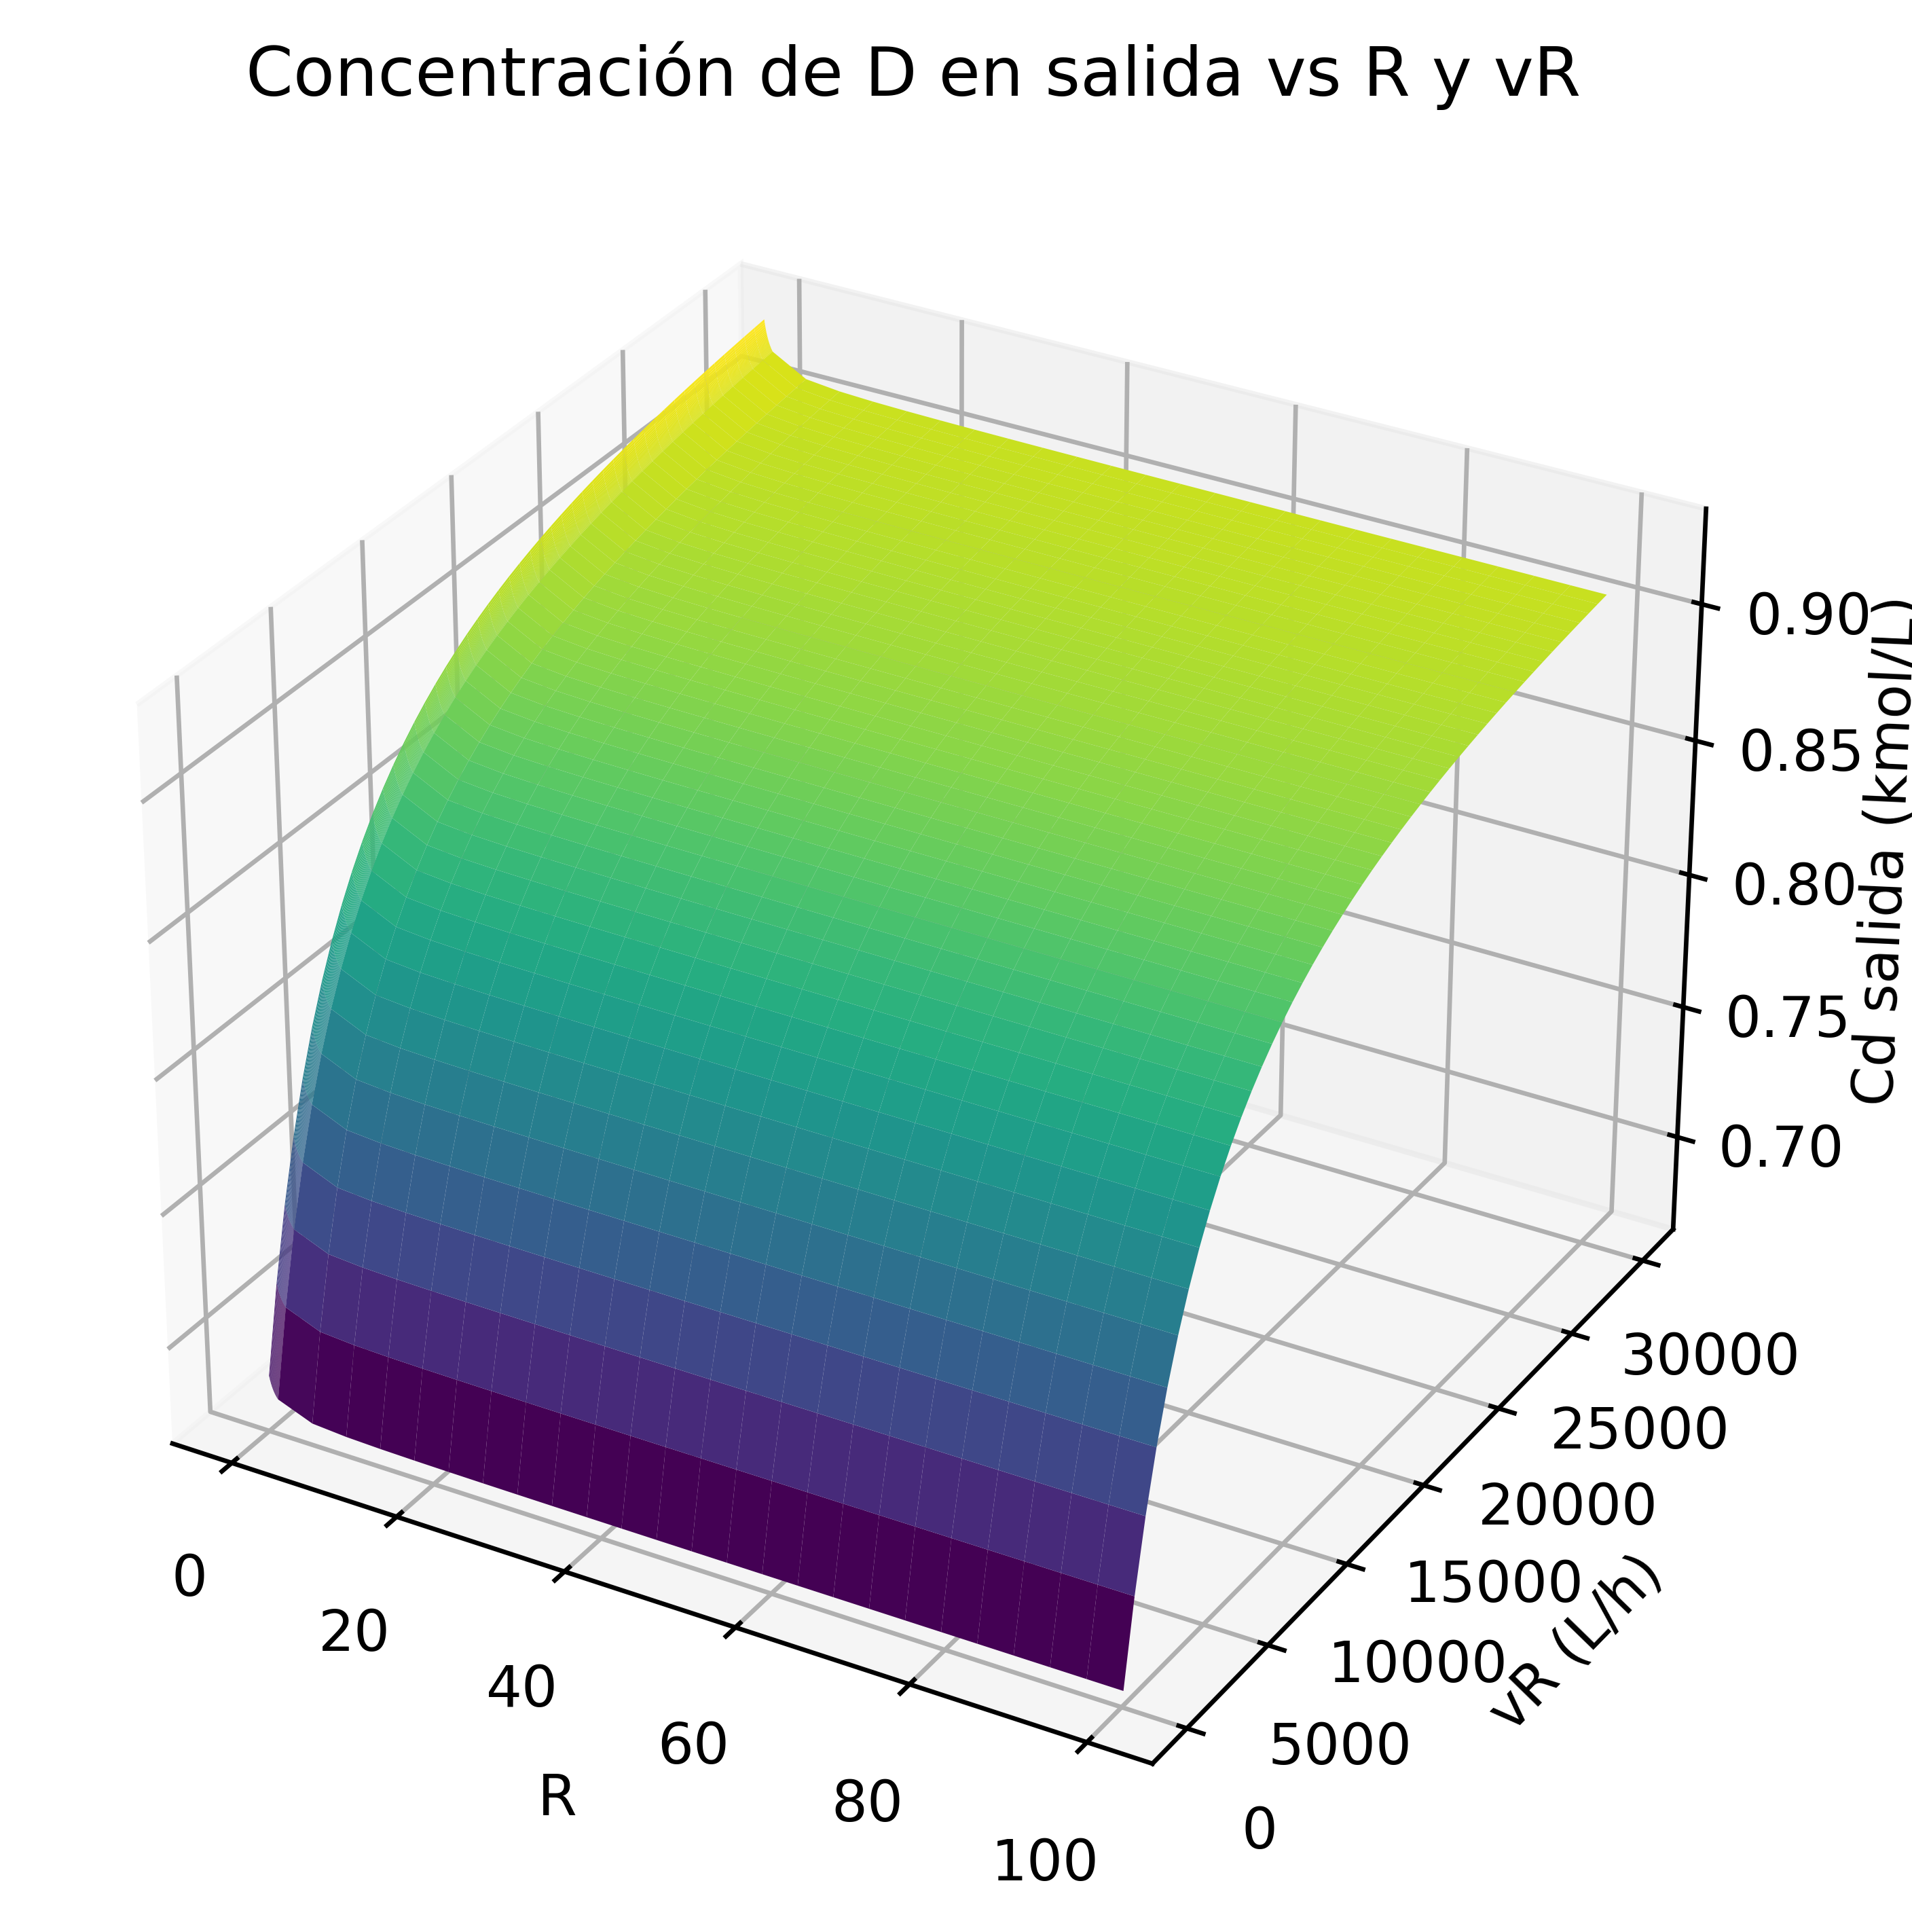

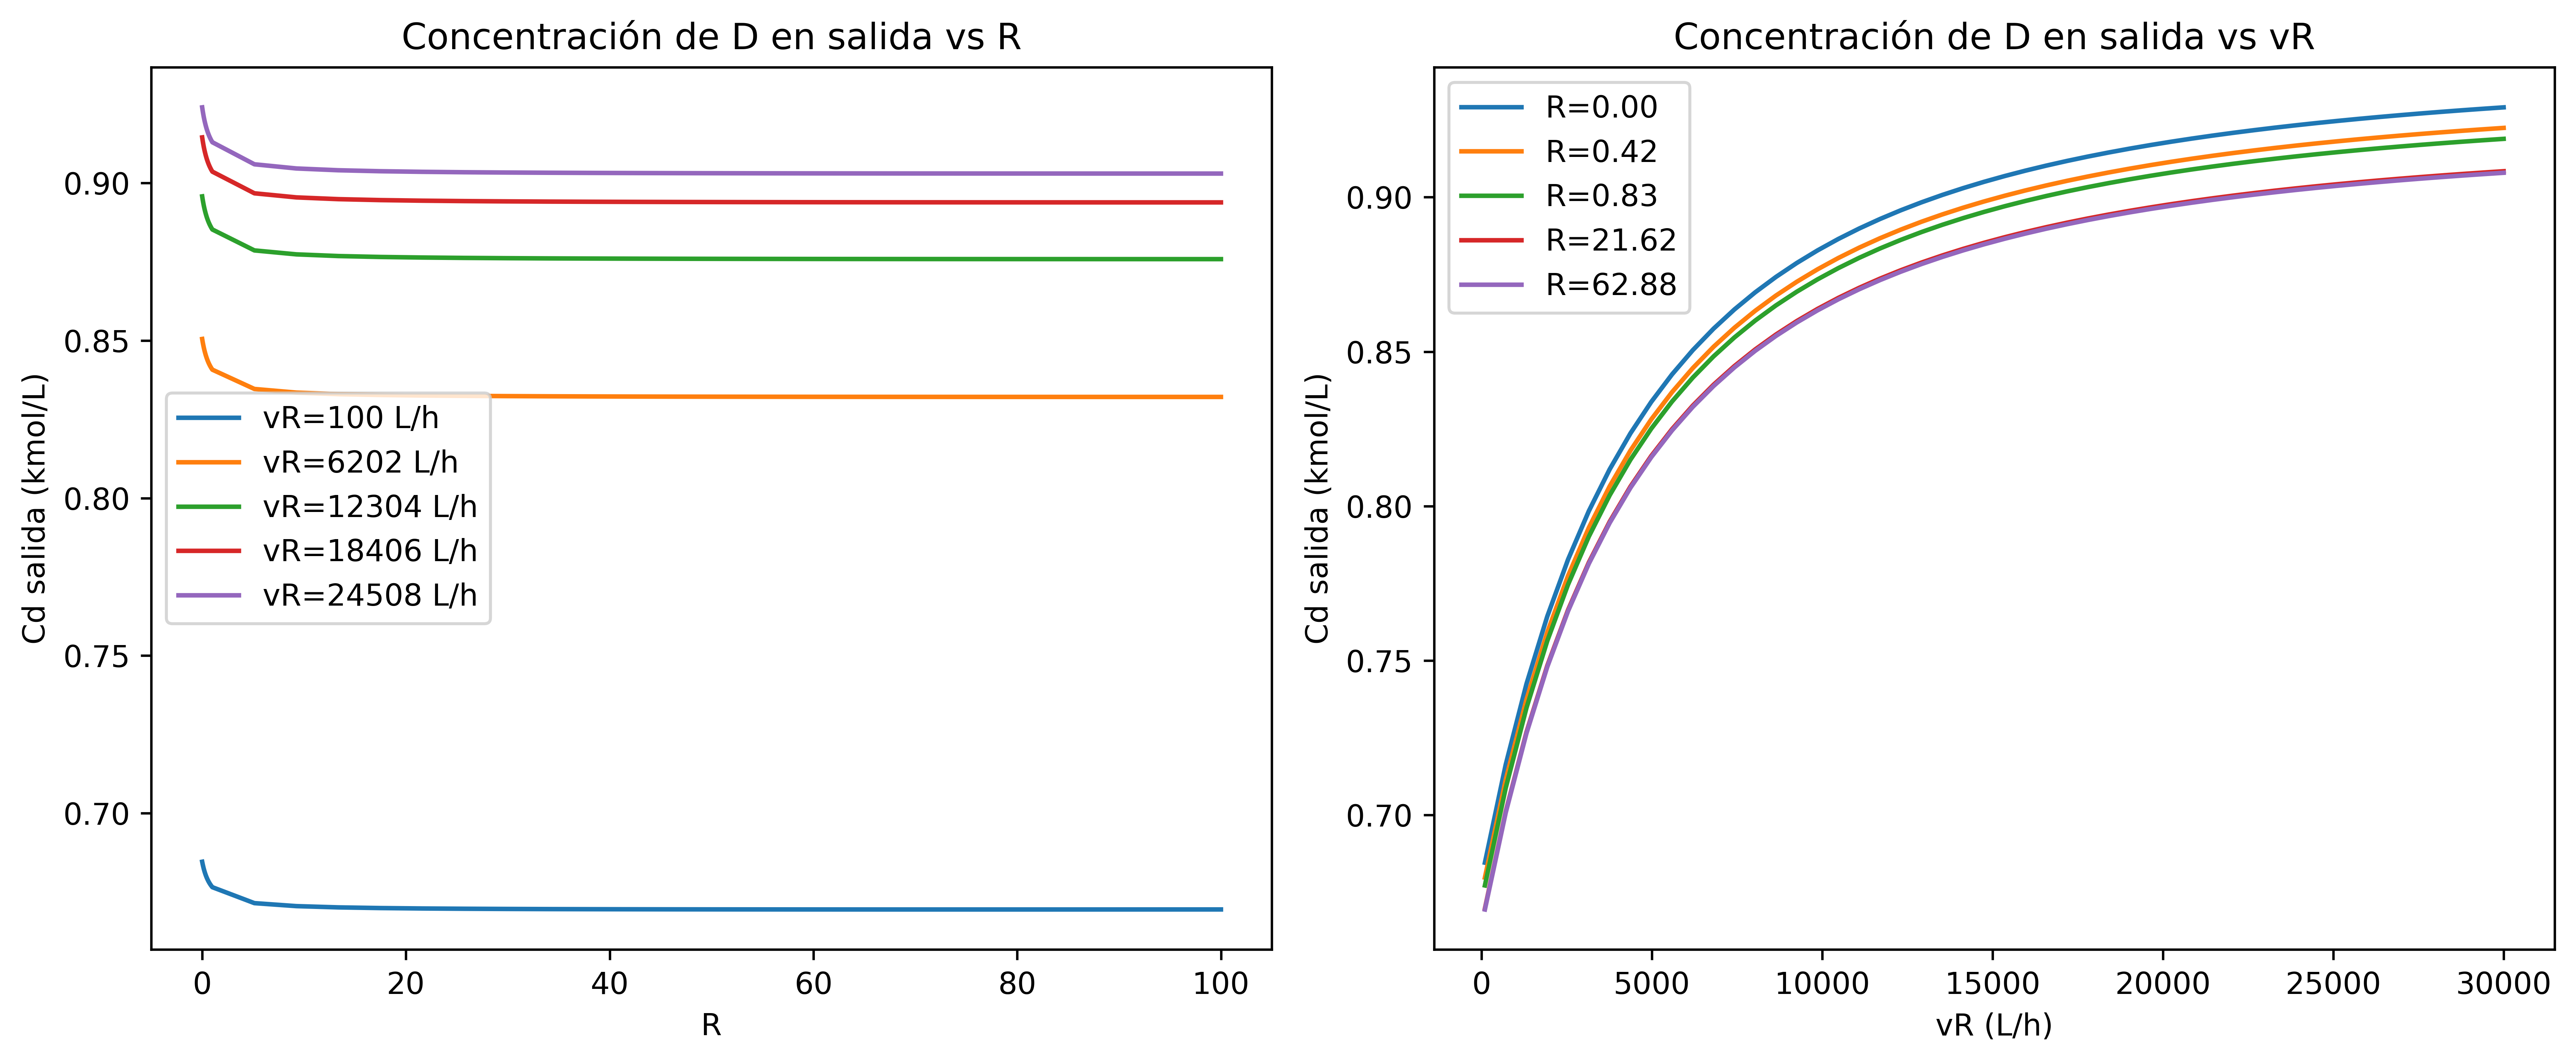

In [92]:
fig = plt.figure(dpi=600)
R_mesh, vR_mesh = np.meshgrid(R_vals, vR_vals)
Cd_mesh = np.zeros_like(R_mesh)
for i in range(R_mesh.shape[0]):    
    for j in range(R_mesh.shape[1]):
        R_val = R_mesh[i, j]
        vR_val = vR_mesh[i, j]
        Cd_mesh[i, j] = dict_results[(vR_val, R_val)][2] # concentracion D salida
ax3d = fig.add_subplot(111, projection='3d',
                        elev=30)
ax3d.plot_surface(R_mesh, vR_mesh, Cd_mesh, cmap='viridis')
ax3d.set_xlabel('R')
ax3d.set_ylabel('vR (L/h)')
ax3d.set_zlabel('Cd salida (kmol/L)')
ax3d.zaxis.labelpad=0.7
ax3d.set_title('Concentración de D en salida vs R y vR')
plt.tight_layout()


# plots 2D
fig2, ax2 = plt.subplots(1, 2, figsize=(12, 5), dpi=600)
# plot Cd vs R para varios vR 
for vR in vR_vals[::10]: # tomamos cada 10 
    Cd_vals = []
    for R in R_vals:
        Cd_vals.append(dict_results[(vR, R)][2])
    ax2[0].plot(R_vals, Cd_vals, label=f'vR={vR:.0f} L/h')
ax2[0].set_xlabel('R')
ax2[0].set_ylabel('Cd salida (kmol/L)')
ax2[0].set_title('Concentración de D en salida vs R')
ax2[0].legend()
# plot Cd vs vR para varios R
for R in R_vals[::10]: # tomamos cada 10
    Cd_vals = []
    for vR in vR_vals:
        Cd_vals.append(dict_results[(vR, R)][2])
    ax2[1].plot(vR_vals, Cd_vals, label=f'R={R:.2f}')
ax2[1].set_xlabel('vR (L/h)')
ax2[1].set_ylabel('Cd salida (kmol/L)')
ax2[1].set_title('Concentración de D en salida vs vR')
ax2[1].legend()
plt.tight_layout()


Utilizamos los valores de R = 0 y vR = 2*v0

In [ ]:
def define_volumes(v0, vR2, R):
    v0 = v0
    v3 = v0 # estado estacionario
    vR1 = R * v3
    v1 = v0 + vR1
    v2 = (R+1) * v3
    vR2 = vR2
    v4 = v3 + vR2
    v5 = v4
    v6 = v0 # estado estacionario
    return v0, v1, v2, v3, vR1, v4, v5, v6, vR2


r = 0
vr = 2 * v0 #L/h
dict_results = {}

# solucion del pfr1 con reciclo
cR1 = np.zeros(5) # initial guess de reciclo del pfr1
converged_pfr1 = False
v0, v1, v2, v3, vR1, v4, v5, v6, vR2 = define_volumes(v0, vr, r) # volumenes definidos previamente
while not converged_pfr1:
    # punto de mezcla 0, 1, vR1
    
    CaR1, CbR1, CcR1, CdR1, CeR1 = cR1
    Ca1 = (Ca0 * v0 + CaR1 * vR1) / v1
    Cb1 = (Cb0 * v0 + CbR1 * vR1) / v1
    Cc1 = (Cc0 * v0 + CcR1 * vR1) / v1
    Cd1 = (Cd0 * v0 + CdR1 * vR1) / v1
    Ce1 = (Ce0 * v0 + CeR1 * vR1) / v1
    # balance PFR 1
    sol_pfr1 = solve_ivp(pfr_dV, [0, V1], [Ca1, Cb1, Cc1, Cd1, Ce1], args=(k1, k2, v1), method='LSODA')
    Ca2, Cb2, Cc2, Cd2, Ce2 = sol_pfr1.y[:, -1]
    # balance reciclo pfr1
    Ca3 = CaR1_new = Ca2 # recordemos que las concentraciones en 2, 3, y R1 son iguales
    Cb3 = CbR1_new = Cb2
    Cc3 = CcR1_new = Cc2
    Cd3 = CdR1_new = Cd2
    Ce3 = CeR1_new = Ce2
    # convergencia pfr1
    if np.allclose([CaR1_new, CbR1_new, CcR1_new, CdR1_new, CeR1_new], cR1, atol=1e-6):
        converged_pfr1 = True
    cR1 = [CaR1_new, CbR1_new, CcR1_new, CdR1_new, CeR1_new]
# despues de este while tenemos las concentraciones de 3
# solución del sistema B (ver pauta)
CaR2 = 0 # initial guess de reciclo del pfr2
converged_B = False # convergencia del sistema B
while not converged_B:
    # punto de mezcla 3, 4, y R2
    Ca4 = (Ca3 * v3 + CaR2 * vR2) / v4
    Cb4 = (Cb3 * v3 ) / v4
    Cc4 = (Cc3 * v3 ) / v4
    Cd4 = (Cd3 * v3 ) / v4
    Ce4 = (Ce3 * v3 ) / v4
    # balance PFR 2
    sol_pfr2 = solve_ivp(pfr_dV, [0, V2], [Ca4, Cb4, Cc4, Cd4, Ce4], args=(k1, k2, v4), method='LSODA')
    Ca5, Cb5, Cc5, Cd5, Ce5 = sol_pfr2.y[:, -1]
    # balance del separador de benceno
    CaR2_new = (Ca5 * v5) / vR2
    Cb6 = (Cb5 * v5) / v6
    Cc6 = (Cc5 * v5) / v6
    Cd6 = (Cd5 * v5) / v6
    Ce6 = (Ce5 * v5) / v6
    # convergencia sistema B
    if abs(CaR2_new - CaR2) < 1e-6:
        converged_B = True
    CaR2 = CaR2_new
dict_results[(vr, r)] = (Cb6, Cc6, Cd6, Ce6) # guardamos los resultados una vez convergidos
    

In [20]:
# valores

print(f'Concentración de salida B: {Cb6:.4f} kmol/L & {Cb6 * 1000} kmol/m^3')
print(f'Concentración de salida C: {Cc6:.4f} kmol/L & {Cc6 * 1000} kmol/m^3')
print(f'Concentración de salida D: {Cd6:.4f} kmol/L & {Cd6 * 1000} kmol/m^3')
print(f'Concentración de salida E: {Ce6:.4f} kmol/L & {Ce6 * 1000} kmol/m^3')

# selectividad global del de monoclorobenceno sobre diclorobenceno
S = Cd6 / Ce6
print(f'Selectividad global de monoclorobenceno sobre diclorobenceno: {S:.4f}')

Concentración de salida B: 3.8836 kmol/L & 3883.63756115624 kmol/m^3
Concentración de salida C: 1.1164 kmol/L & 1116.3624388437624 kmol/m^3
Concentración de salida D: 0.8836 kmol/L & 883.6360986679595 kmol/m^3
Concentración de salida E: 0.1164 kmol/L & 116.36317008790152 kmol/m^3
Selectividad global de monoclorobenceno sobre diclorobenceno: 7.5938


# BONUS

## B

In [99]:

def pfr_dV(t, x, k1, k2, v):
    '''
    Define el sistema de ecuciones diferenciales para el reactor de flujo pistón (PFR).
    Este toma la forma 
    dF/dV = r
    donde F es el vector de flujos molares y r es el vector de velocidades de reacción.
    ---
    Reference:
    Fogler, H. S. (2016). Elements of chemical reaction engineering (Fifth edition). Prentice-Hall, Pearson.
    Pagina 16.
    
    '''
    Ca, Cb, Cc, Cd, Ce = x
    dCa_dV = 1/v * (-k1 * Ca * Cb)
    dCb_dV = 1/v * (-k1 * Ca * Cb - k2 * Cb * Cc)
    dCc_dV = 1/v * (k1 * Ca * Cb + k2 * Cb * Cc)
    dCd_dV = 1/v * (k1 * Ca * Cb - k2 * Cb * Cc)
    dCe_dV = 1/v * (k2 * Cb * Cc)
    return [dCa_dV, dCb_dV, dCc_dV, dCd_dV, dCe_dV]

# definimos los valores que conocemos
# constantes de velocidad
k1 = 0.412 # L/kmol h
k2 = 0.055 # L/kmol h
# concentraciones del flujo de entrada
Ca0 = 1 # kmol / L
Cb0 = 5 # kmol / L
Cc0 = 0 # kmol / L
Cd0 = 0 # kmol / L
Ce0 = 0 # kmol / L
# valor del flujo de entrada
v0 = 10 # m^3/h
# ahora escalamos para que v0 quede en unidades de L/h
v0 = v0 * 1000 # L/h
# tamaño de reactores
V1 = 5.56 # m^3
V2 = 11.607 # m^3
# ahora escalamos para que V1 y V2 queden en unidades de L
V1 = V1 * 1000 # L
V2 = V2 * 1000 # L

Es posible notar que se pueden pre-calcular las corrientes del proceso, lo que permite simplificar la resolución, especialmente en los casos del bonús que son más complejos.

In [ ]:
def define_volumes(v0, vR2, R):
    v0 = v0
    vR2 = vR2
    v1 = v0 + vR2
    v4 = v1
    v3 = (R+1) * v4
    vR1 = R * v4
    v2 = v1 + vR1
    v5 = v4 
    v6 = v0 
    return v0, v1, v2, v3, v4, v5, v6, vR1, vR2

R_vals = np.concatenate((np.linspace(0, 1, 25),np.linspace(1, 10, 25))) # sacamos varios entre 0 hasta 1 y 1 hasta 100
vR_vals = np.linspace(100, v0*3, 50)
dict_results = {}
for R in R_vals:
    for vR2 in vR_vals:
        v0, v1, v2, v3, v4, v5, v6, vR1, vR2 = define_volumes(v0, vR2, R)
        converged = False
        # initial guess de CaR2
        CaR2 = 0
        while not converged:
            # empezamos a resolver el sistema
            # balance de masa punto de mezcla 0, R2, 1
            Ca1 = (Ca0 * v0 + CaR2 * vR2) / v1
            Cb1 = (Cb0 * v0 ) / v1
            # balance del pfr1 con reciclo R1
            
            pfr1_convergence = False
            # initial guess concentraciones de reciclo del pfr

                
            c_R1 = np.zeros(5)
            while not pfr1_convergence:
                Ca2 = (Ca1 * v1 + c_R1[0] * vR1) / v2
                Cb2 = (Cb1 * v1 + c_R1[1] * vR1) / v2
                Cc2 = (c_R1[2] * vR1) / v2
                Cd2 = (c_R1[3] * vR1) / v2
                Ce2 = (c_R1[4] * vR1) / v2
                c2 = [Ca2, Cb2, Cc2, Cd2, Ce2]
                # resolvemos el sistema de ODEs para el PFR 1
                sol1 = solve_ivp(fun=pfr_dV,
                                t_span = (0, V1), # recordar que t_span es la variable independiente en este caso el volumen
                                y0 = c2, # condicion inicial
                                args = (k1, k2, v2), # parametros
                )
                Ca3, Cb3, Cc3, Cd3, Ce3 = sol1.y[:,-1] # extraemos las concentraciones en la salida del PFR
                # recordemos que las concentraciones en el reciclo son las mismas en las 3 corrientes
                Ca4 = CaR1 = Ca3
                Cb4 = CbR1 = Cb3
                Cc4 = CcR1 = Cc3
                Cd4 = CdR1 = Cd3
                Ce4 = CeR1 = Ce3
                # verificamos convergencia
                c_R1_new = [CaR1, CbR1, CcR1, CdR1, CeR1]
                if np.allclose(c_R1, c_R1_new, atol=1e-10):
                    pfr1_convergence = True
                c_R1 = c_R1_new.copy()

            # despues del ciclo anterior deberímos obtener las concentraciones en la corriente 4
            # balance del pfr2
            sol2 = solve_ivp(fun=pfr_dV,
                            t_span = (0, V2), # recordar que t_span es la variable independiente en este caso el volumen
                            y0 = [Ca4, Cb4, Cc4, Cd4, Ce4], # condicion inicial
                            args = (k1, k2, v4), # parametros
            )
            
            Ca5, Cb5, Cc5, Cd5, Ce5 = sol2.y[:,-1] # extraemos las concentraciones en la salida del PFR
            # balance del separador de benceno
            CaR2_new = (Ca5 * v5) / vR2 # new porque se comparar
            Cb6 = (Cb5 * v5) / v6
            Cc6 = (Cc5 * v5) / v6
            Cd6 = (Cd5 * v5) / v6
            Ce6 = (Ce5 * v5) / v6
            if abs(CaR2_new - CaR2) < 1e-6:
                converged = True
                
            CaR2 = CaR2_new
        dict_results[(R, vR2)] = [Cb6, Cc6, Cd6, Ce6] # guardamos fuera del while
        




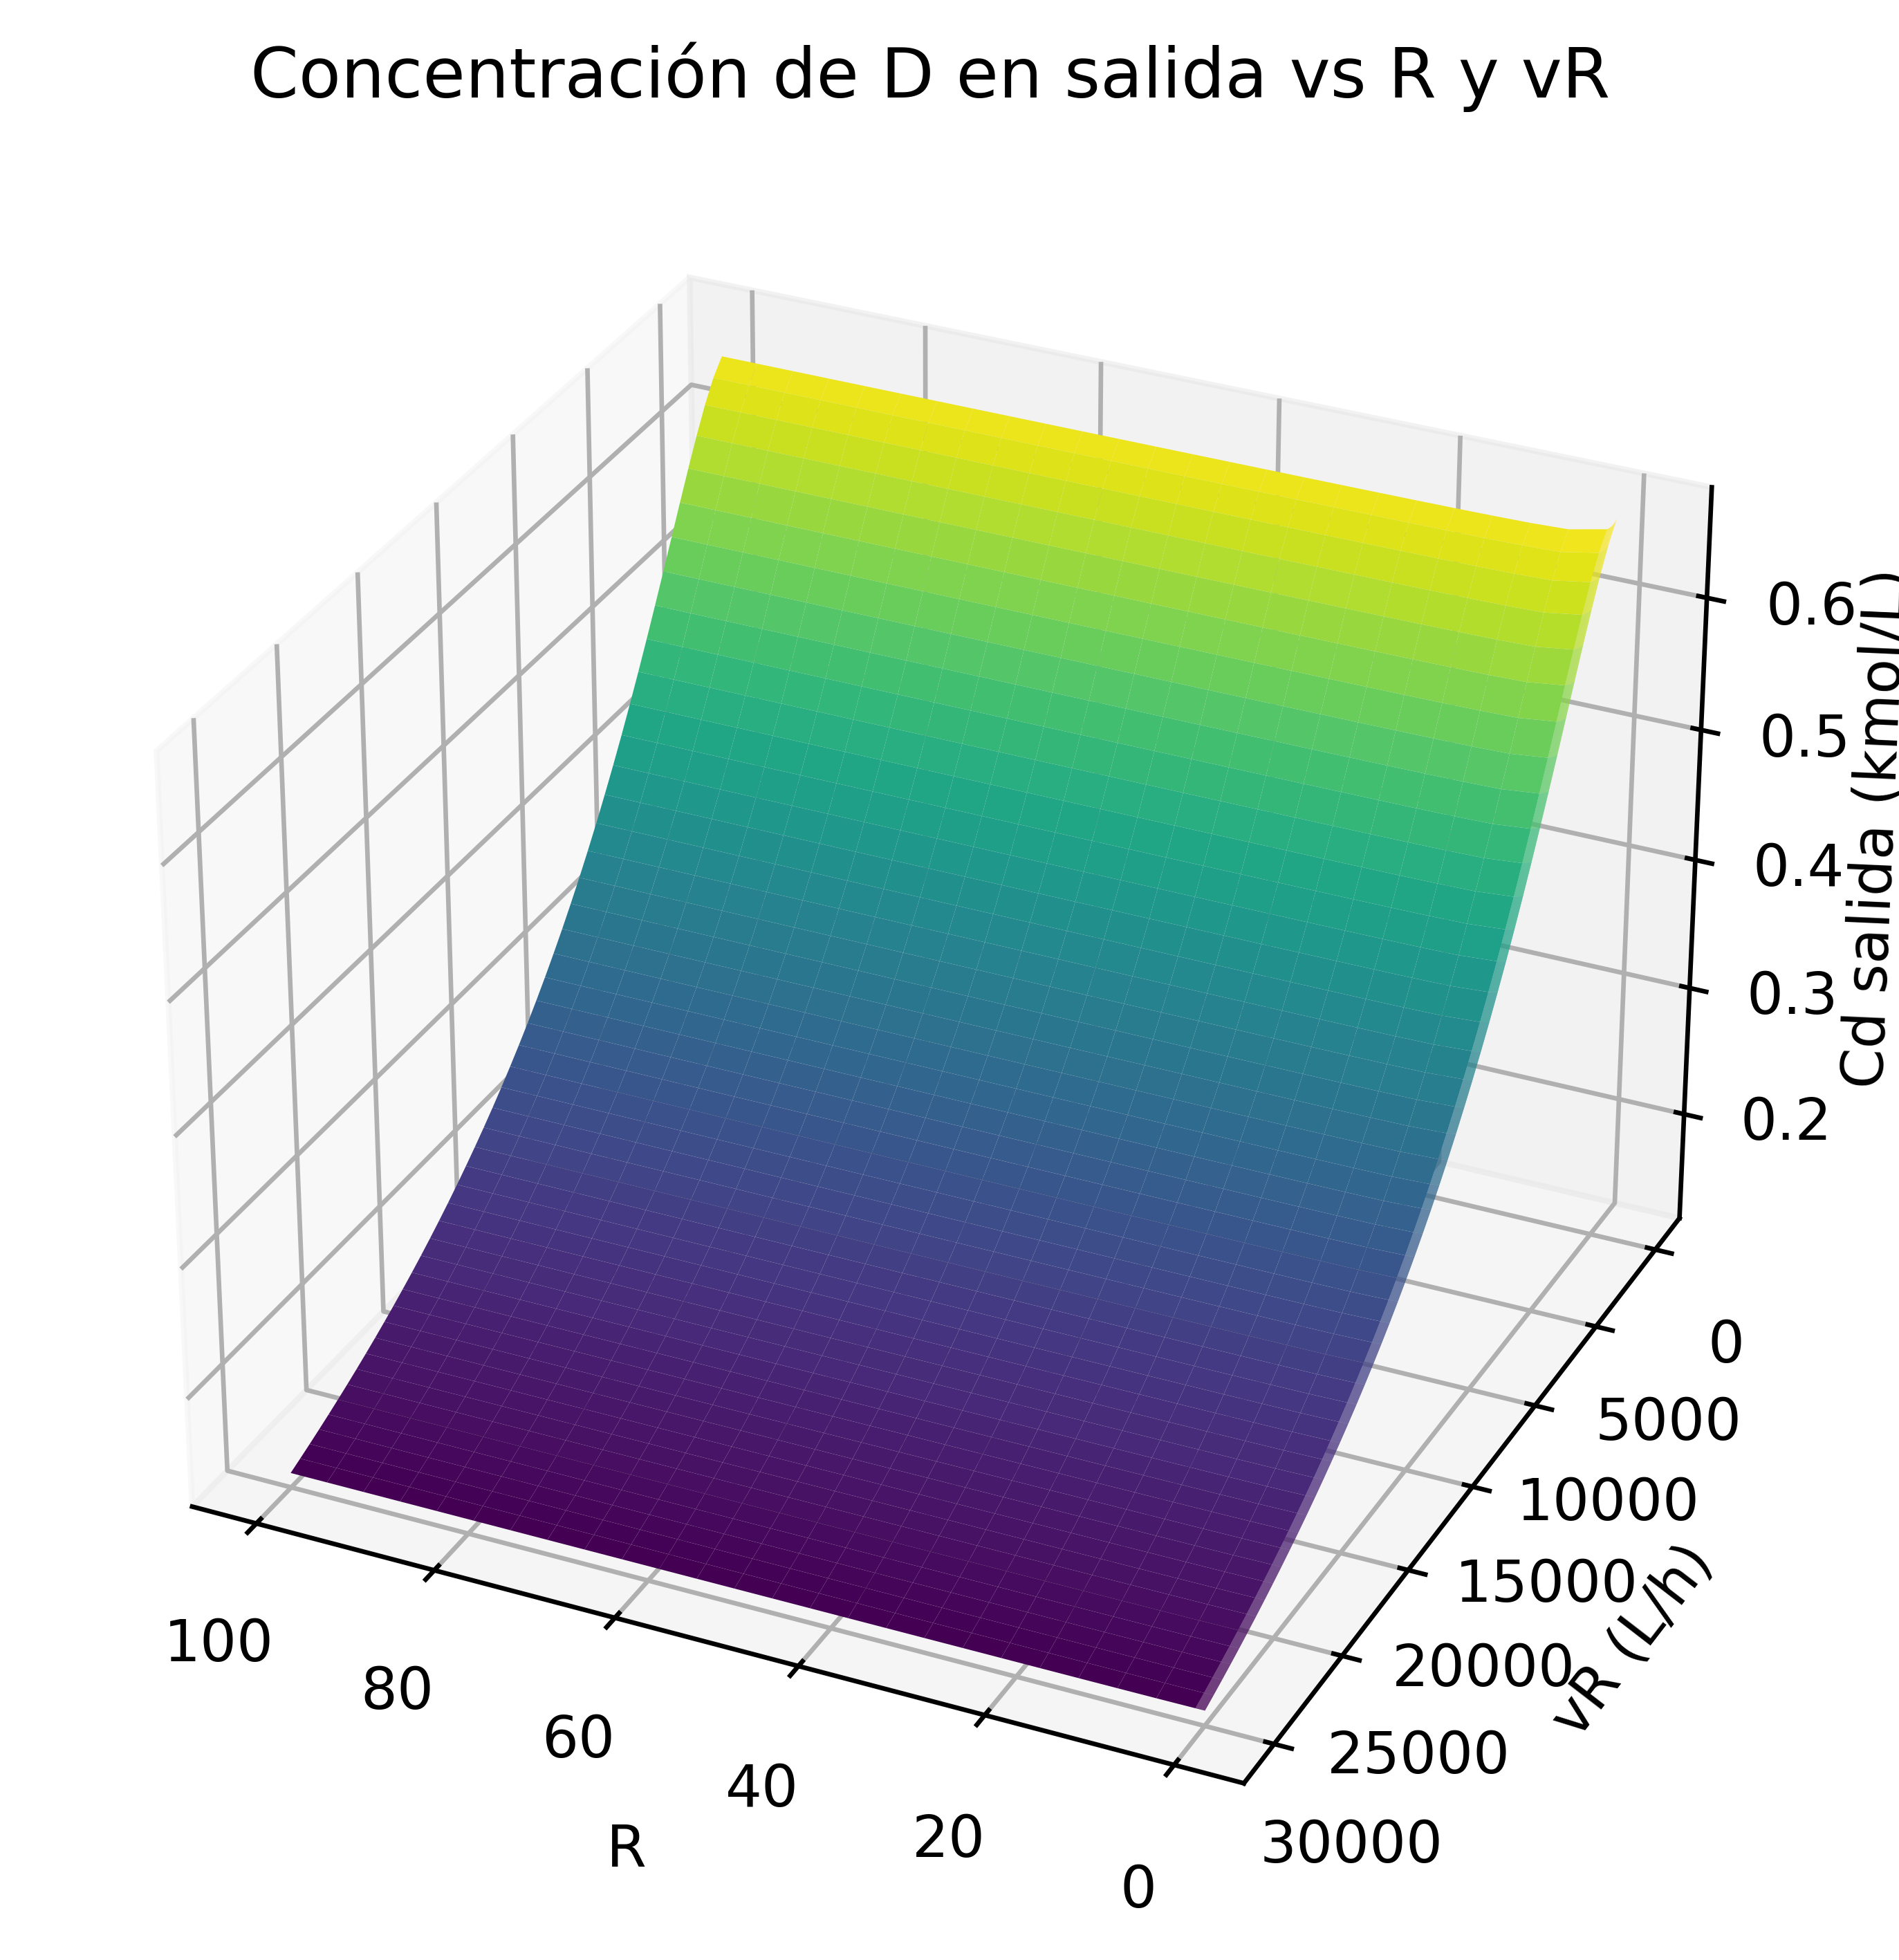

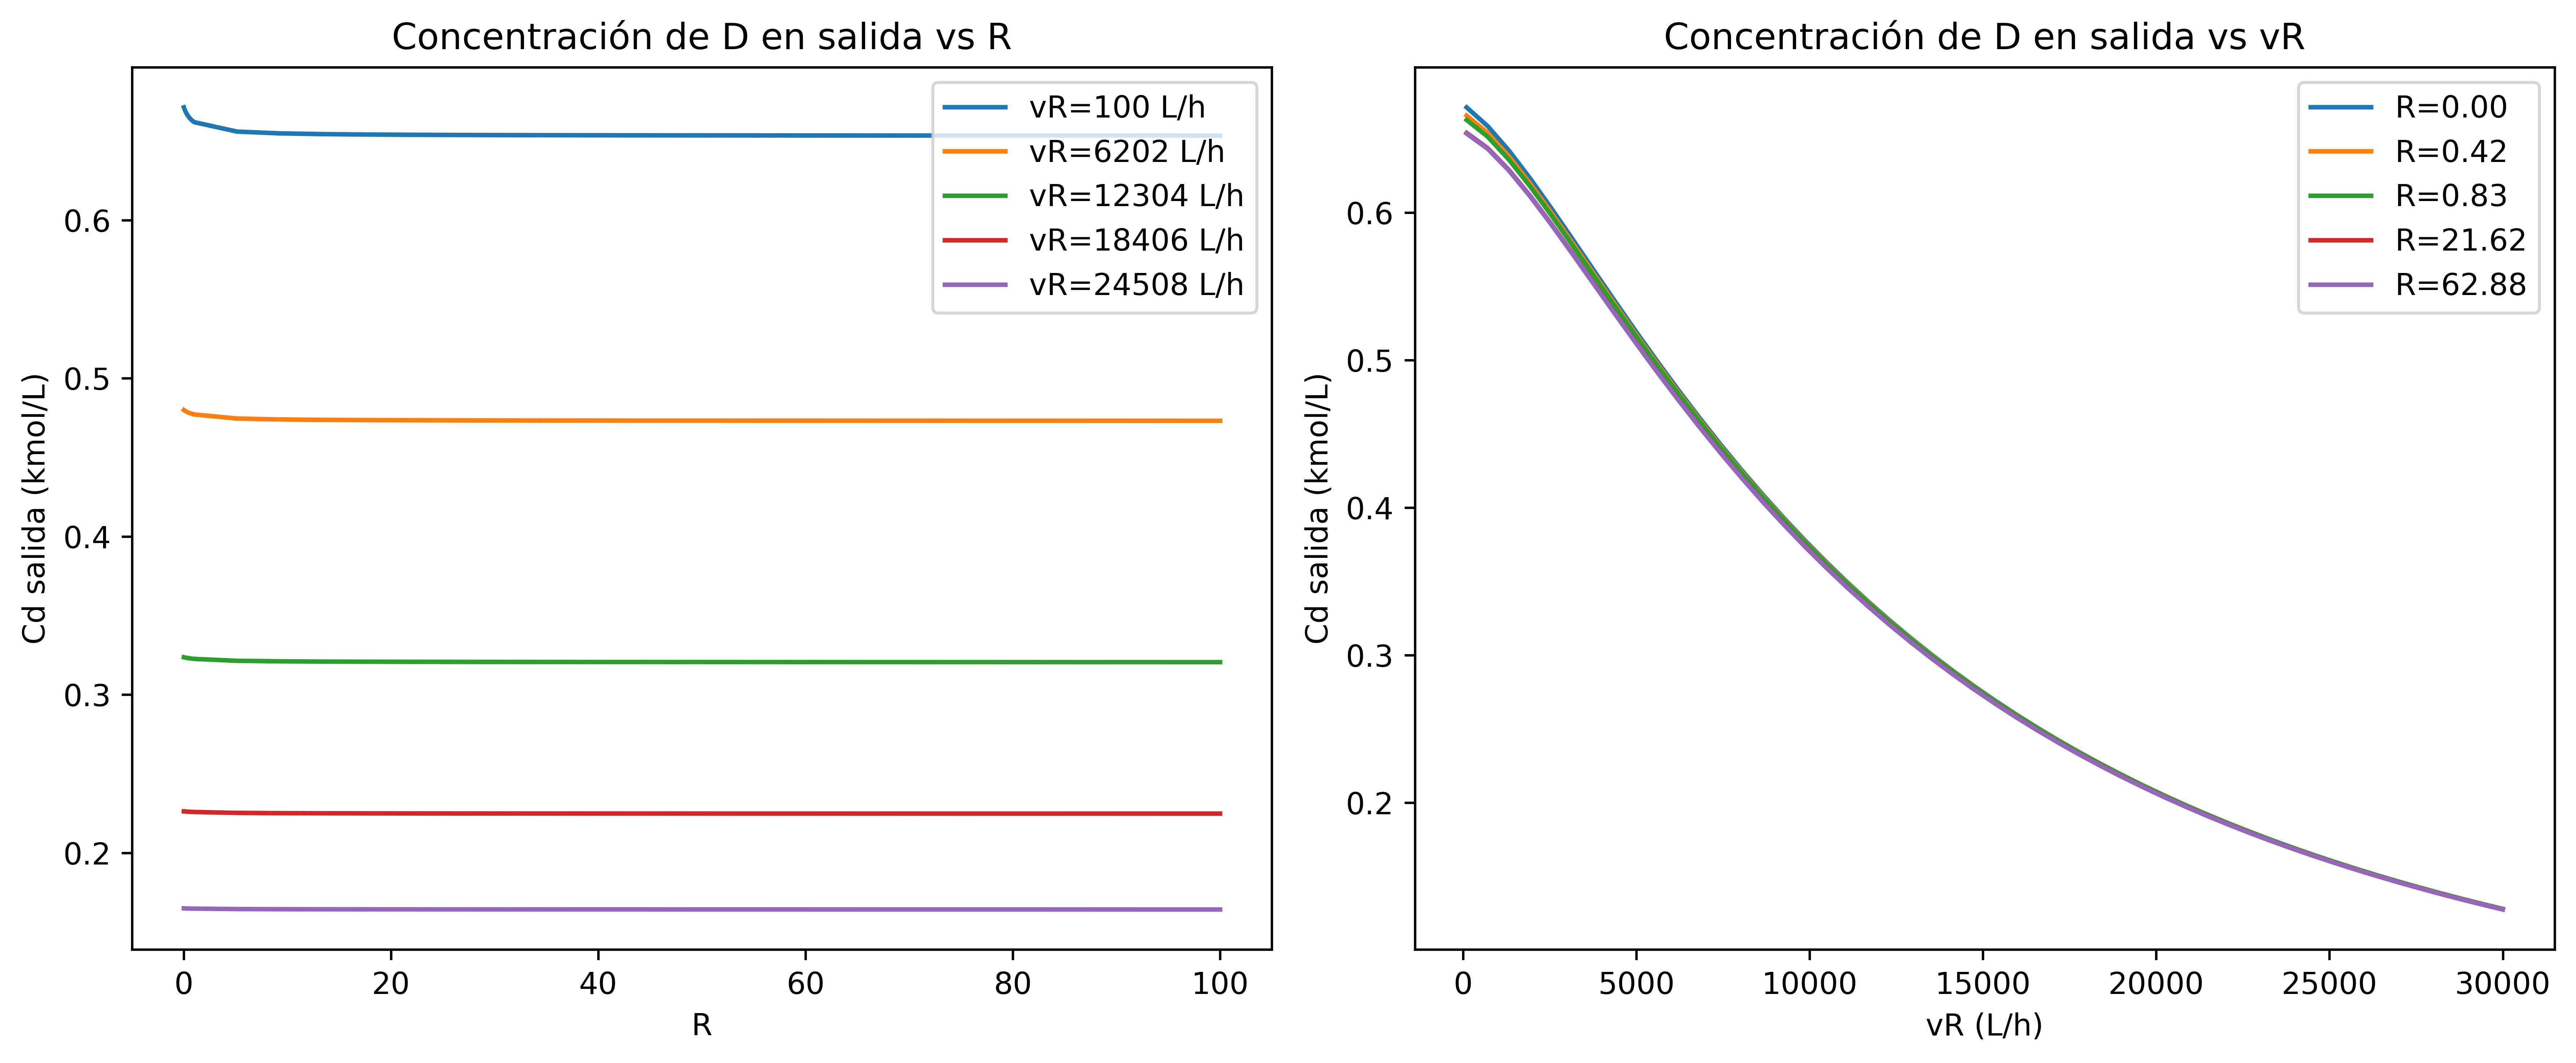

In [111]:
fig = plt.figure(dpi=600)
R_mesh, vR_mesh = np.meshgrid(R_vals, vR_vals)
Cd_mesh = np.zeros_like(R_mesh)
for i in range(R_mesh.shape[0]):    
    for j in range(R_mesh.shape[1]):
        R_val = R_mesh[i, j]
        vR_val = vR_mesh[i, j]
        Cd_mesh[i, j] = dict_results[(R_val, vR_val)][2] # concentracion D salida
ax3d = fig.add_subplot(111, projection='3d',
                        azim=115)
ax3d.plot_surface(R_mesh, vR_mesh, Cd_mesh, cmap='viridis')
ax3d.set_xlabel('R')
ax3d.set_ylabel('vR (L/h)')
ax3d.set_zlabel('Cd salida (kmol/L)')
ax3d.zaxis.labelpad=-0.7
ax3d.set_title('Concentración de D en salida vs R y vR')
plt.tight_layout()


# plots 2D
fig2, ax2 = plt.subplots(1, 2, figsize=(12, 5), dpi=600)
# plot Cd vs R para varios vR 
for vR in vR_vals[::10]: # tomamos cada 10 
    Cd_vals = []
    for R in R_vals:
        Cd_vals.append(dict_results[(R, vR)][2])
    ax2[0].plot(R_vals, Cd_vals, label=f'vR={vR:.0f} L/h')
ax2[0].set_xlabel('R')
ax2[0].set_ylabel('Cd salida (kmol/L)')
ax2[0].set_title('Concentración de D en salida vs R')
ax2[0].legend()
# plot Cd vs vR para varios R
for R in R_vals[::10]: # tomamos cada 10
    Cd_vals = []
    for vR in vR_vals:
        Cd_vals.append(dict_results[(R, vR)][2])
    ax2[1].plot(vR_vals, Cd_vals, label=f'R={R:.2f}')
ax2[1].set_xlabel('vR (L/h)')
ax2[1].set_ylabel('Cd salida (kmol/L)')
ax2[1].set_title('Concentración de D en salida vs vR')
ax2[1].legend()
plt.tight_layout()


In [115]:
def define_volumes(v0, vR2, R):
    v0 = v0
    vR2 = vR2
    v1 = v0 + vR2
    v4 = v0
    v3 = (R+1) * v4
    vR1 = R * v4
    v2 = v1 + vR1
    v5 = v4 
    v6 = v0 
    return v0, v1, v2, v3, v4, v5, v6, vR1, vR2

R = 1e-10
vR2 = 1

v0, v1, v2, v3, v4, v5, v6, vR1, vR2 = define_volumes(v0, vR2, R)
converged = False
# initial guess de CaR2
CaR2 = 0
while not converged:
    # empezamos a resolver el sistema
    # balance de masa punto de mezcla 0, R2, 1
    Ca1 = (Ca0 * v0 + CaR2 * vR2) / v1
    Cb1 = (Cb0 * v0 ) / v1
    # balance del pfr1 con reciclo R1
    
    pfr1_convergence = False
    # initial guess concentraciones de reciclo del pfr
    c_R1 = np.zeros(5)
    while not pfr1_convergence:
        Ca2 = (Ca1 * v1 + c_R1[0] * vR1) / v2
        Cb2 = (Cb1 * v1 + c_R1[1] * vR1) / v2
        Cc2 = (c_R1[2] * vR1) / v2
        Cd2 = (c_R1[3] * vR1) / v2
        Ce2 = (c_R1[4] * vR1) / v2
        c2 = [Ca2, Cb2, Cc2, Cd2, Ce2]
        # resolvemos el sistema de ODEs para el PFR 1
        sol1 = solve_ivp(fun=pfr_dV,
                        t_span = (0, V1), # recordar que t_span es la variable independiente en este caso el volumen
                        y0 = c2, # condicion inicial
                        args = (k1, k2, v2), # parametros
        )
        Ca3, Cb3, Cc3, Cd3, Ce3 = sol1.y[:,-1] # extraemos las concentraciones en la salida del PFR
        # recordemos que las concentraciones en el reciclo son las mismas en las 3 corrientes
        Ca4 = CaR1 = Ca3
        Cb4 = CbR1 = Cb3
        Cc4 = CcR1 = Cc3
        Cd4 = CdR1 = Cd3
        Ce4 = CeR1 = Ce3
        # verificamos convergencia
        c_R1_new = [CaR1, CbR1, CcR1, CdR1, CeR1]
        if np.allclose(c_R1, c_R1_new, atol=1e-10):
            pfr1_convergence = True
        c_R1 = c_R1_new.copy()
    # despues del ciclo anterior deberímos obtener las concentraciones en la corriente 4
    # balance del pfr2
    sol2 = solve_ivp(fun=pfr_dV,
                    t_span = (0, V2), # recordar que t_span es la variable independiente en este caso el volumen
                    y0 = [Ca4, Cb4, Cc4, Cd4, Ce4], # condicion inicial
                    args = (k1, k2, v4), # parametros
    )
    
    Ca5, Cb5, Cc5, Cd5, Ce5 = sol2.y[:,-1] # extraemos las concentraciones en la salida del PFR
    # balance del separador de benceno
    CaR2_new = (Ca5 * v5) / vR2 # new porque se comparar
    Cb6 = (Cb5 * v5) / v6
    Cc6 = (Cc5 * v5) / v6
    Cd6 = (Cd5 * v5) / v6
    Ce6 = (Ce5 * v5) / v6
    if abs(CaR2_new - CaR2) < 1e-6:
        converged = True
        
    CaR2 = CaR2_new
dict_results[(R, vR2)] = [Cb6, Cc6, Cd6, Ce6] # guardamos fuera del while



In [116]:
# valores

print(f'Concentración de salida B: {Cb6:.4f} kmol/L')
print(f'Concentración de salida C: {Cc6:.4f} kmol/L')
print(f'Concentración de salida D: {Cd6:.4f} kmol/L')
print(f'Concentración de salida E: {Ce6:.4f} kmol/L')

# selectividad global del de monoclorobenceno sobre diclorobenceno
S = Cd6 / Ce6
print(f'Selectividad global de monoclorobenceno sobre diclorobenceno: {S:.4f}')

Concentración de salida B: 3.6725 kmol/L
Concentración de salida C: 1.3270 kmol/L
Concentración de salida D: 0.6728 kmol/L
Concentración de salida E: 0.3271 kmol/L
Selectividad global de monoclorobenceno sobre diclorobenceno: 2.0570


## D

In [ ]:

def pfr_dV(t, x, k1, k2, v):
    '''
    Define el sistema de ecuciones diferenciales para el reactor de flujo pistón (PFR).
    Este toma la forma 
    dF/dV = r
    donde F es el vector de flujos molares y r es el vector de velocidades de reacción.
    ---
    Reference:
    Fogler, H. S. (2016). Elements of chemical reaction engineering (Fifth edition). Prentice-Hall, Pearson.
    Pagina 16.
    
    '''
    Ca, Cb, Cc, Cd, Ce = x
    dCa_dV = 1/v * (-k1 * Ca * Cb)
    dCb_dV = 1/v * (-k1 * Ca * Cb - k2 * Cb * Cc)
    dCc_dV = 1/v * (k1 * Ca * Cb + k2 * Cb * Cc)
    dCd_dV = 1/v * (k1 * Ca * Cb - k2 * Cb * Cc)
    dCe_dV = 1/v * (k2 * Cb * Cc)
    return [dCa_dV, dCb_dV, dCc_dV, dCd_dV, dCe_dV]

# definimos los valores que conocemos
# constantes de velocidad
k1 = 0.412 # L/kmol h
k2 = 0.055 # L/kmol h
# concentraciones del flujo de entrada
Ca0 = 1 # kmol / L
Cb0 = 5 # kmol / L
Cc0 = 0 # kmol / L
Cd0 = 0 # kmol / L
Ce0 = 0 # kmol / L
# valor del flujo de entrada
v0 = 10 # m^3/h
# ahora escalamos para que v0 quede en unidades de L/h
v0 = v0 * 1000 # L/h
# tamaño de reactores
V1 = 5.56 # m^3
V2 = 11.607 # m^3
# ahora escalamos para que V1 y V2 queden en unidades de L
V1 = V1 * 1000 # L
V2 = V2 * 1000 # L
# definimos un R 

Al igual que antes definimos una solución para los flujos del sistema

In [ ]:
def define_volumes(v0, vR3, R1, R2):
    v0 = v0
    vR3 = vR3
    v1 = v0 + vR3
    v4 = v1
    v3 = (R1+1) * v4
    vR1 = R1 * v4
    v2 = v1 + vR1
    v7 = v4
    v6 = (R2+1) * v7
    vR2 = R2 * v7
    v5 = v4 + vR2
    v8 = v0 
    return v0, v1, v2, v3, v4, v5, v6, v7, v8, vR1, vR2, vR3

R1_vals = np.concatenate((np.linspace(0, 1, 10),np.linspace(1, 50, 10))) # sacamos varios entre 0 hasta 1 y 1 hasta 50
R2_vals = np.concatenate((np.linspace(0, 1, 10),np.linspace(1, 50, 10))) 
vR3_vals = np.linspace(100, v0*3, 20)
dict_results = {}
for R1 in R1_vals:
    for R2 in R2_vals:
        for vR3 in vR3_vals:
            v0, v1, v2, v3, v4, v5, v6, v7, v8, vR1, vR2, vR3 = define_volumes(v0, vR3, R1, R2)
            converged =False
            # initial guess de CaR2
            CaR2 = 0
            while not converged:
                # punto de mezcla 0, R1, 2
                Ca1 = (Ca0 * v0 + CaR2 * vR3) / v1
                Cb1 = (Cb0 * v0) / v1
                # balance del pfr1 con reciclo R1
                pfr1_convergence = False
                # initial guess concentraciones de reciclo del pfr
                c_R1 = np.zeros(5)
                while not pfr1_convergence:
                    Ca2 = (Ca1 * v1 + c_R1[0] * vR1) / v2
                    Cb2 = (Cb1 * v1 + c_R1[1] * vR1) / v2
                    Cc2 = (c_R1[2] * vR1) / v2
                    Cd2 = (c_R1[3] * vR1) / v2
                    Ce2 = (c_R1[4] * vR1) / v2
                    c2 = [Ca2, Cb2, Cc2, Cd2, Ce2]
                    # resolvemos el sistema de ODEs para el PFR 1
                    sol1 = solve_ivp(fun=pfr_dV,
                                    t_span = (0, V1), # recordar que t_span es la variable independiente en este caso el volumen
                                    y0 = c2, # condicion inicial
                                    args = (k1, k2, v2), # parametros
                    )
                    Ca3, Cb3, Cc3, Cd3, Ce3 = sol1.y[:,-1] # extraemos las concentraciones en la salida del PFR
                    # recordemos que las concentraciones en el reciclo son las mismas en las 3 corrientes
                    Ca4 = CaR1 = Ca3
                    Cb4 = CbR1 = Cb3
                    Cc4 = CcR1 = Cc3
                    Cd4 = CdR1 = Cd3
                    Ce4 = CeR1 = Ce3
                    # verificamos convergencia
                    c_R1_new = [CaR1, CbR1, CcR1, CdR1, CeR1]
                    if np.allclose(c_R1, c_R1_new, atol=1e-10):
                        pfr1_convergence = True
                    c_R1 = c_R1_new.copy()
                # despues del ciclo anterior deberímos obtener las concentraciones en la corriente 4
                # balance del pfr2 con reciclo R2
                pfr2_convergence = False
                c_R2 = np.zeros(5)
                while not pfr2_convergence:
                    Ca5 = (Ca4 * v4 + c_R2[0] * vR2) / v5
                    Cb5 = (Cb4 * v4 + c_R2[1] * vR2) / v5
                    Cc5 = (Cc4 * v4 + c_R2[2] * vR2) / v5
                    Cd5 = (Cd4 * v4 + c_R2[3] * vR2) / v5
                    Ce5 = (Ce4 * v4 + c_R2[4] * vR2) / v5
                    c5 = [Ca5, Cb5, Cc5, Cd5, Ce5]
                    # resolvemos el sistema de ODEs para el PFR 2
                    sol2 = solve_ivp(fun=pfr_dV,
                                    t_span = (0, V2), # recordar que t_span es la variable independiente en este caso el volumen
                                    y0 = c5, # condicion inicial
                                    args = (k1, k2, v5), # parametros
                    )
                    Ca6, Cb6, Cc6, Cd6, Ce6 = sol2.y[:,-1] # extraemos las concentraciones en la salida del PFR
                    # recordemos que las concentraciones en el reciclo son las mismas en las 3 corrientes
                    Ca7 = CaR2 = Ca6
                    Cb7 = CbR2 = Cb6
                    Cc7 = CcR2 = Cc6
                    Cd7 = CdR2 = Cd6
                    Ce7 = CeR2 = Ce6
                    # verificamos convergencia
                    c_R2_new = [CaR2, CbR2, CcR2, CdR2, CeR2]
                    if np.allclose(c_R2, c_R2_new, atol=1e-10):
                        pfr2_convergence = True
                    c_R2 = c_R2_new.copy()
                # despues del ciclo anterior deberímos obtener las concentraciones en la corriente 7
                # balance del separador de benceno
                CaR2_new = (Ca7 * v7) / vR2 # new porque se comparar
                Cb8 = (Cb7 * v7) / v8
                Cc8 = (Cc7 * v7) / v8
                Cd8 = (Cd7 * v7) / v8   
                Ce8 = (Ce7 * v7) / v8
                if abs(CaR2_new - CaR2) < 1e-6:
                    converged = True
                CaR2 = CaR2_new
            dict_results[(R1, R2, vR3)] = [Cb8, Cc8, Cd8, Ce8] # guardamos fuera del while  